In [119]:
import warnings
warnings.filterwarnings('ignore')

In [120]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.independencies import IndependenceAssertion


df = pd.read_csv("US_Accidents_March23.csv")
print(f'dfset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [121]:
df.columns
len(df.columns)

46

In [122]:
df.drop(['ID', 'Source', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Description', 'Street', 'City', 'County', 'Zipcode', 
           'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Wind_Direction', 'Amenity', 'Bump', 'Give_Way', 'No_Exit', 'Railway', 'Distance(mi)',
           'Roundabout', 'Station', 'Traffic_Calming', 'Turning_Loop', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Pressure(in)', 'Wind_Chill(F)'], axis=1, inplace=True)

df.dropna(inplace=True)

In [123]:
data = df.copy(deep=True)

In [124]:
df.columns

Index(['Severity', 'State', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Crossing',
       'Junction', 'Stop', 'Traffic_Signal', 'Sunrise_Sunset'],
      dtype='object')

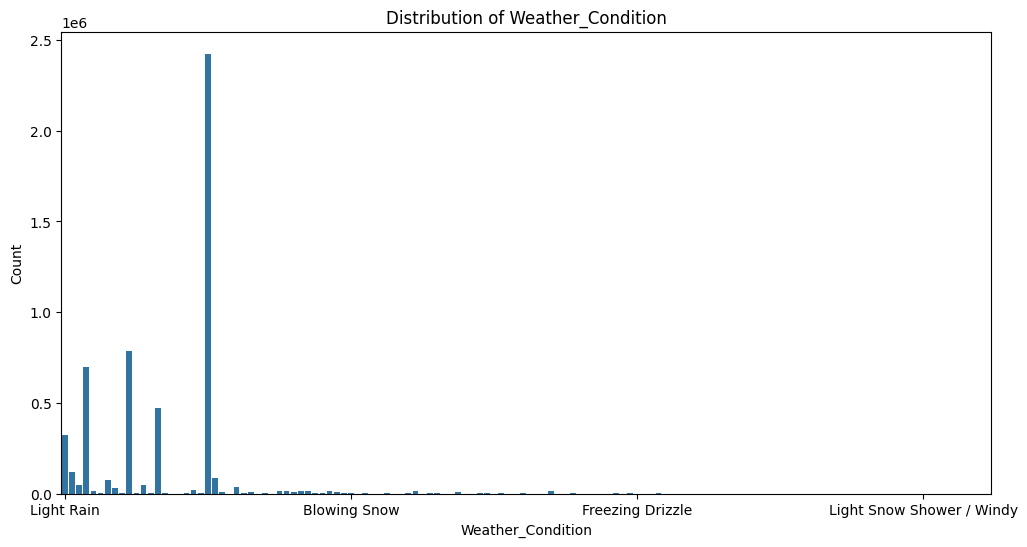

In [125]:
cols_to_discretize = [
    # 'Wind_Speed(mph)',
    'Weather_Condition',
]

for col in cols_to_discretize:
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(x=data[col])
    ticks = ax.get_xticks()
    ax.set_xticks(ticks[::40])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

**Temperature(F)**

- -45 = Cold
- 45-80 = Mild
- 80+ = Hot

**Visibility(mi)**

- -3.0 = Low visibility
- 3.0 - 7.0 = Moderate visibility
- 7.0+ = High visibility

**Wind speed(mph)**

- 0 - 10.0 = Low wind speed
- 10.0 - 25.0 = Moderate wind speed
- 25.0+ = High wind speed

**Precipitation(in)**

- 0 - 0.005 = Low precipitation
- 0.005 - 0.3 = Moderate precipitation
- 0.3 = High precipitation


In [126]:
# Equal-Width Binning (era meglio Quantile-Based Discretization ???)
discrete_bins = 3

cols_to_discretize = [
     'Humidity(%)', 
]

for col in cols_to_discretize:
    min_val = data[col].min()
    max_val = data[col].max()
    # Creazione dei bin con ampiezza fissa
    bins = pd.cut(data[col], bins=np.linspace(min_val, max_val, discrete_bins+1), include_lowest=True)
    print(f"{col} -> {bins.dtype.categories}")
    bin2int = {x: i for i, x in enumerate(bins.dtype.categories)}
    data[col] = bins.apply(lambda x: bin2int[x]).astype(np.uint8)


#Discretize Temperature
bins = [-float('inf'), 45, 80, float('inf')]  # Intervalli
labels = [1, 2, 3]  # Etichette corrispondenti
data['Temperature(F)'] = pd.cut(data['Temperature(F)'], bins=bins, labels=labels)

#Discretize Visibility
bins = [-float('inf'), 3.0, 7.0, float('inf')]
labels = [1, 2, 3]
data['Visibility(mi)'] = pd.cut(data['Visibility(mi)'], bins=bins, labels=labels)

#Discretize Wind speed
bins = [-float('inf'), 10.0, 25.0, float('inf')]
labels = [1, 2, 3]
data['Wind_Speed(mph)'] = pd.cut(data['Wind_Speed(mph)'], bins=bins, labels=labels)

#Discretize Precipitation
bins = [-float('inf'), 0.005, 0.3, float('inf')]
labels = [1, 2, 3]
data['Precipitation(in)'] = pd.cut(data['Precipitation(in)'], bins=bins, labels=labels)

# # Mostriamo il risultato
# plt.figure(figsize=(12, 6))
# ax = sns.countplot(x=data['Precipitation(in)'])
# ticks = ax.get_xticks()
# ax.set_xticks(ticks[::50])
# plt.title(f'Distribution of wind speed')
# plt.xlabel('Precipitation(in)')
# plt.ylabel('Count')
# plt.show()


In [127]:
data.describe(include='all')

,Severity,State,Temperature(F),Humidity(%),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Crossing,Junction,Stop,Traffic_Signal,Sunrise_Sunset
count,5.374832e+06,5374832,5374832.0,5.374832e+06,5374832.0,5374832.0,5374832.0,5374832,5374832,5374832,5374832,5374832,5374832
unique,NaN,49,3.0,NaN,3.0,3.0,3.0,130,2,2,2,2,2
top,NaN,CA,2.0,NaN,3.0,1.0,1.0,Fair,False,False,False,False,Day
freq,NaN,1146356,3396125.0,NaN,4510255.0,4119409.0,4868498.0,2424538,4792311,5003041,5227113,4673904,3646926
mean,2.155319e+00,NaN,NaN,1.395643e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.498935e-01,NaN,NaN,6.831676e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.000000e+00,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000e+00,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.000000e+00,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
data.info()

In [129]:
data.head()

,Severity,State,Temperature(F),Humidity(%),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Crossing,Junction,Stop,Traffic_Signal,Sunrise_Sunset
5,3,OH,1,2,2,1,2,Light Rain,False,False,False,False,Day
9,3,OH,1,2,1,1,2,Light Rain,False,False,False,False,Day
11,3,OH,1,2,1,1,2,Light Rain,False,False,False,False,Day
14,2,OH,1,2,1,1,2,Light Rain,False,False,False,True,Day
20,2,OH,1,2,1,1,2,Light Snow,False,False,False,False,Day


### Custom model

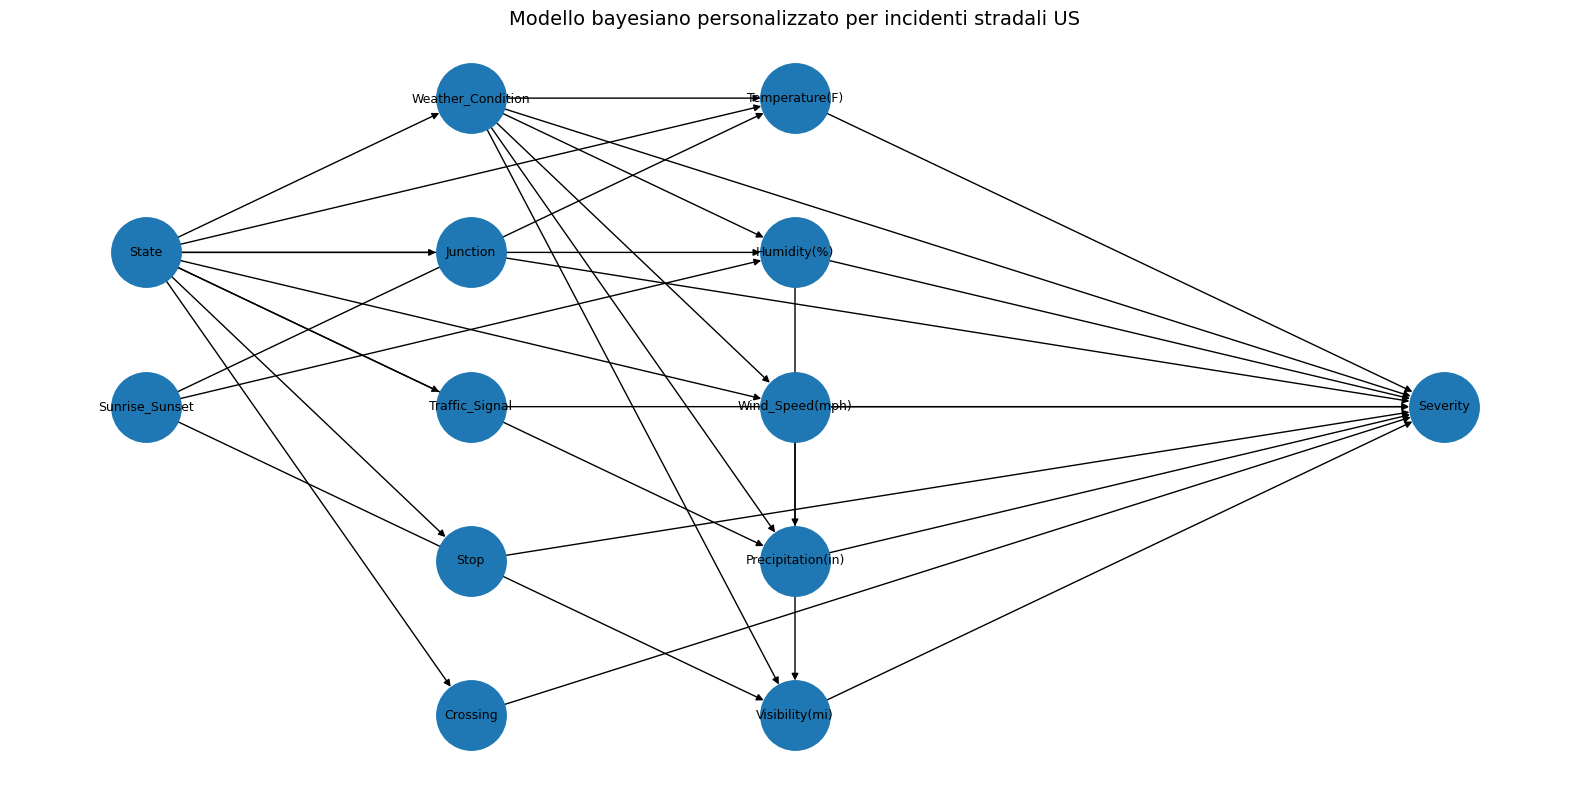

In [130]:
# Definizione del modello bayesiano con relazioni personalizzate
custom_model = BayesianModel([
    # Relazioni legate allo stato e all'ambiente
    ('State', 'Weather_Condition'),
    ('State', 'Junction'),
    ('State', 'Traffic_Signal'),
    ('State', 'Stop'),
    ('State', 'Crossing'),
    ('State', 'Temperature(F)'),
    ('State', 'Humidity(%)'),
    ('State', 'Wind_Speed(mph)'),
    ('State', 'Precipitation(in)'),

    ('Weather_Condition', 'Temperature(F)'),
    ('Weather_Condition', 'Humidity(%)'),
    ('Weather_Condition', 'Wind_Speed(mph)'),
    ('Weather_Condition', 'Precipitation(in)'),
    ('Weather_Condition', 'Visibility(mi)'),
    
    ('Wind_Speed(mph)', 'Visibility(mi)'),
    
    # Influenza di Sunrise_Sunset sulla visibilità
    ('Sunrise_Sunset', 'Visibility(mi)'),
    ('Sunrise_Sunset', 'Temperature(F)'),
    ('Sunrise_Sunset', 'Humidity(%)'),

    ('Weather_Condition', 'Severity'),
    

    ('Humidity(%)', 'Precipitation(in)'),
    
    
    
    # Fattori infrastrutturali e ambientali che influenzano la gravità dell'incidente
    ('Junction', 'Severity'),
    ('Traffic_Signal', 'Severity'),
    ('Stop', 'Severity'),
    ('Crossing', 'Severity'),
    ('Precipitation(in)', 'Severity'),
    ('Visibility(mi)', 'Severity'),
    
    ('Temperature(F)', 'Severity'),
    ('Humidity(%)', 'Severity'),

    ('Wind_Speed(mph)', 'Severity'),
])

# Posizioni dei nodi su una griglia a colonne
pos = {
    # Column 1: Basic factors
    'State': (0, 0),
    'Sunrise_Sunset': (0, -1),

    # Column 2: Environmental signals and junction-related factors
    'Weather_Condition': (2, 1),
    'Junction': (2, 0),
    'Traffic_Signal': (2, -1),
    'Stop': (2, -2),
    'Crossing': (2, -3),

    # Column 3: Weather measurements
    'Temperature(F)': (4, 1),
    'Humidity(%)': (4, 0),
    'Wind_Speed(mph)': (4, -1),
    'Precipitation(in)': (4, -2),
    'Visibility(mi)': (4, -3),
    
    # Column 5: Outcome
    'Severity': (8, -1)
}

# Creazione della figura e disegno del grafo
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
nx.draw_networkx(
    custom_model,
    pos=pos,
    ax=ax,
    node_size=2500,
    font_size=9,
    arrows=True
)

ax.set_title('Modello bayesiano personalizzato per incidenti stradali US', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [131]:
import io
import sys

# Reset learned CPDs and refit the model
custom_model.cpds = []
custom_model.fit(data)

from pgmpy.factors.discrete.CPD import TabularCPD

def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

# Capture printed output using StringIO
old_stdout = sys.stdout
sys.stdout = mystdout = io.StringIO()

# Print all the learned CPTs
for cpd in custom_model.get_cpds():
    print('CPT of {}'.format(cpd.variable))
    print_full(cpd)
    print('\n')

# Restore original stdout
sys.stdout = old_stdout

# Save captured output to a file
with open('CPDs.txt', 'w', encoding='utf-8') as file:
    file.write(mystdout.getvalue())

Building tree:   0%|          | 0/78.0 [00:00<?, ?it/s]

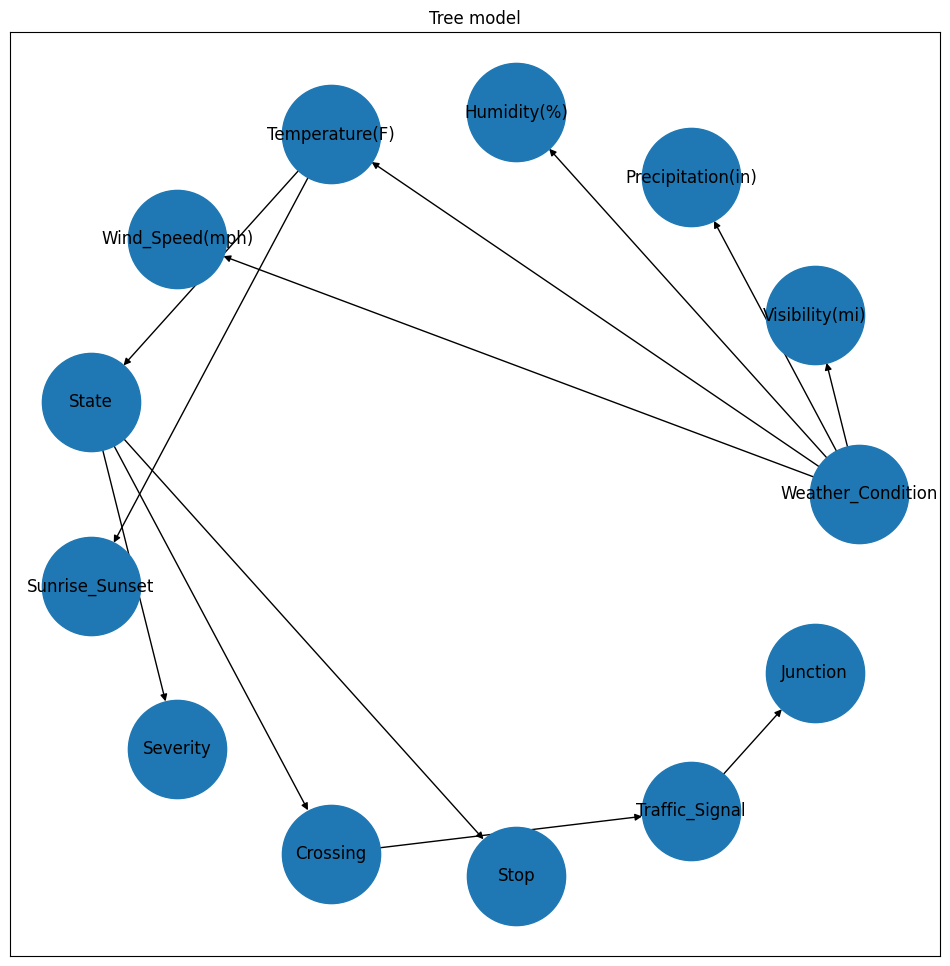

In [132]:
# ts = TreeSearch(data=data, root_node='State')
ts = TreeSearch(data=data)
tree_model = ts.estimate()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=5000)
# fig.savefig('tree')
ax.set_title('Tree model')
tree_model = BayesianModel(tree_model.edges())

In [133]:
# scorer = BDeuScore(data=data)
# hc = HillClimbSearch(data=data)
# hc_base_model = hc.estimate(scoring_method=scorer)

# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# nx.draw_networkx(hc_base_model, pos=nx.drawing.layout.circular_layout(hc_base_model), ax=ax, node_size=5000)
# # fig.savefig('hc_base')
# ax.set_title('HC base model')
# hc_base_model = BayesianModel(hc_base_model.edges())

### Questions

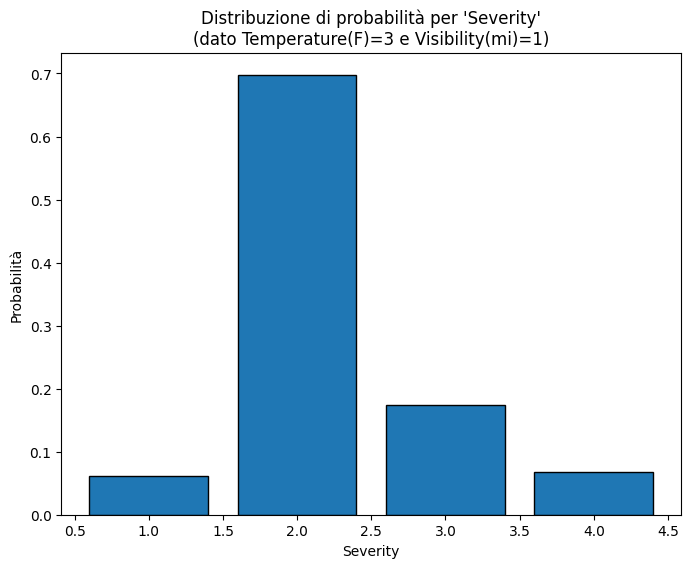

In [137]:
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt

# Crea l'oggetto per l'inferenza sul modello personalizzato (già adattato con custom_model.fit(data))
infer = VariableElimination(custom_model)

# Eseguiamo la query: condizioniamo su Temperature(F)=3 e Visibility(mi)=1
query_result = infer.query(variables=['Severity'], evidence={'Temperature(F)': 3, 'Visibility(mi)': 1})
print("Risultato della query di inferenza per 'Severity':")
print(query_result)

# Estraiamo gli stati e le probabilità
states = query_result.state_names['Severity']
probabilities = query_result.values

# Creiamo il grafico a barre per visualizzare la distribuzione
plt.figure(figsize=(8, 6))
plt.bar(states, probabilities, edgecolor='black')
plt.xlabel("Severity")
plt.ylabel("Probabilità")
plt.title("Distribuzione di probabilità per 'Severity'\n(dato Temperature(F)=3 e Visibility(mi)=1)")
plt.show()


Qual è la distribuzione di probabilità per la gravità dell'incidente (Severity) dato che:

la temperatura è alta (Temperature(F) = 3),
la visibilità è bassa (Visibility(mi) = 1),
la velocità del vento è elevata (Wind_Speed(mph) = 3)
e le precipitazioni sono elevate (Precipitation(in) = 3)?

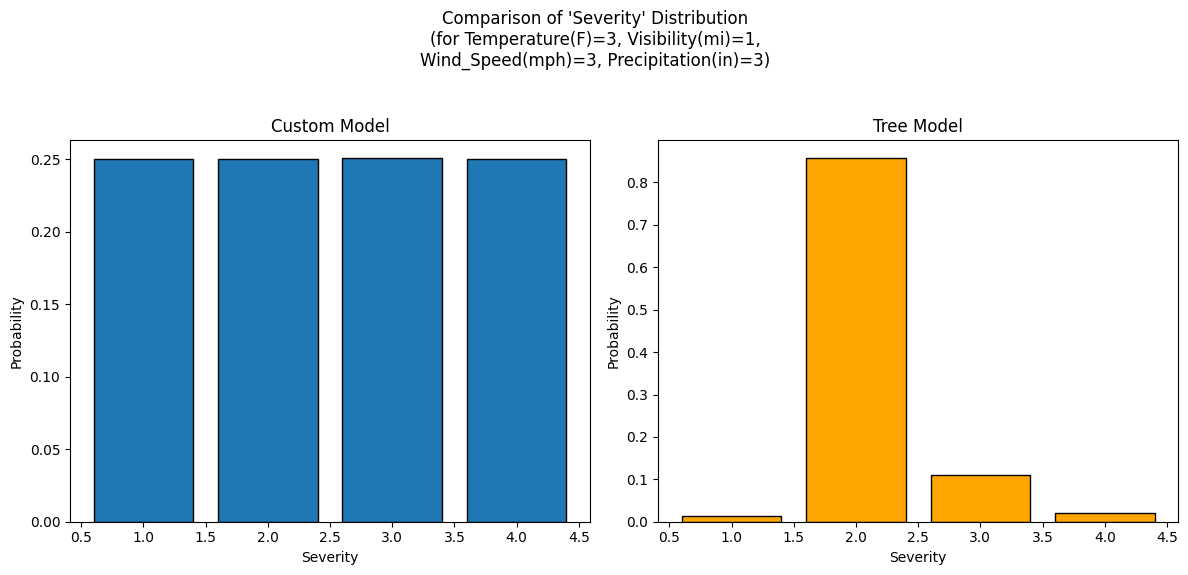

In [138]:
# Ensure the tree model is fitted to the data
tree_model.fit(data)

# Create inference objects for both models
infer_custom = infer_complex  # already defined from custom_model
infer_tree = VariableElimination(tree_model)

# Define the evidence
evidence = {'Temperature(F)': 3, 'Visibility(mi)': 1, 'Wind_Speed(mph)': 3, 'Precipitation(in)': 3}

# Query both models for the distribution of 'Severity'
custom_result = infer_custom.query(variables=['Severity'], evidence=evidence)
tree_result = infer_tree.query(variables=['Severity'], evidence=evidence)

# Extract states and probabilities
states = custom_result.state_names['Severity']
probs_custom = custom_result.values
probs_tree = tree_result.values

# Plot results side by side for comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(states, probs_custom, edgecolor='black')
plt.xlabel("Severity")
plt.ylabel("Probability")
plt.title("Custom Model")

plt.subplot(1, 2, 2)
plt.bar(states, probs_tree, color='orange', edgecolor='black')
plt.xlabel("Severity")
plt.ylabel("Probability")
plt.title("Tree Model")

plt.suptitle("Comparison of 'Severity' Distribution\n(for Temperature(F)=3, Visibility(mi)=1,\nWind_Speed(mph)=3, Precipitation(in)=3)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
